# Détermination du portrait de phase à partir de la diffusion des particules

## Importation des librairies et des routines

In [3]:
# Import standard libraries
import numpy as np
from scipy.special import gamma
import matplotlib.pyplot as plt
from matplotlib import animation, cm, colors, rc
import random
import time
from imp import reload
rc('animation', html='html5')

# Import library of our own functions
import MPCMolecularDynamics as MD
reload(MD)
from library import *

#Include plots into notebook instead of plotting them in extra window
%matplotlib inline 

### Une première trajectoire

In [53]:
# define system
d=2
NParticles=16
kT = 0.34
m = np.ones(NParticles)

# Lennard-Jones
sigma = 1
epsilon = 1
tau = sigma*np.sqrt(m[0]/epsilon) #unit of time
print('tau=',tau)

# choose density
rho = 0.5/sigma**d
print('Densité=', rho, 'sigma**',d)
LBox = np.power(NParticles/rho,1./d)
print("LBox = ",LBox)

# define the length of the trajectory
run_time = 100. * tau

# generate trajectories and measure execution time
initialWallTime = time.perf_counter()

( t_tr, x_tr, y_tr, vx_tr, vy_tr, uPot_tr, uKin_tr, pPot_tr, pKin_tr, [t,x,y,vx,vy] 
) = Generate_LJ_NVT_MolecularDynamics_Trajectory(d,m,LBox,kT,run_time)

print("Execution time: ",time.perf_counter() - initialWallTime)

tau= 1.0
Densité= 0.5 sigma** 2
LBox =  5.656854249492381
Execution time:  11.440876499999831


Animation de la trajectoire générée:

1


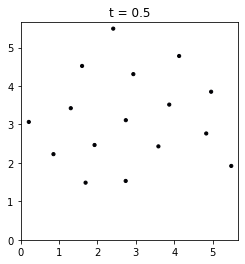

In [38]:
# t_tr contains the times corresponding to the stored energies and pressures, 
# but onfigurations were stored less frequently

# As a consequence we need to skip all the intermediate times in t_tr 
# for which we have no data in x_tr and y_tr
#skip=int( (t_tr.size-1)/(x_tr.shape[0]-1) )
skip=1
print(skip)

MD.AnimateMDRun(t_tr[::skip],x_tr,y_tr,xBox=LBox,xpbc=True,yBox=LBox,ypbc=True,m=m)

Plot des trajectoires des différentes particules

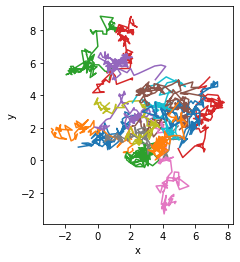

In [54]:
ax = plt.axes()
MD.AddParticleTraces(ax,x_tr,y_tr,range(NParticles))
ax.set_xlabel("x")
ax.set_ylabel("y")
ax.set_aspect(1)
plt.show()

ainsi que leur MSD

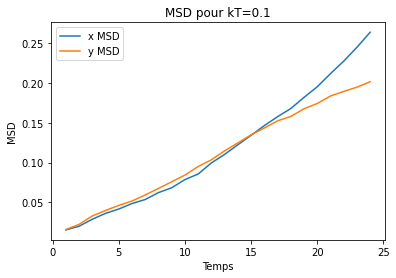

In [4]:
delta_t, x_msd = MeanSquareDisplacements(t_tr,x_tr)
delta_t, y_msd = MeanSquareDisplacements(t_tr,y_tr)
plt.plot(delta_t,x_msd,label='x MSD')
plt.plot(delta_t,y_msd,label='y MSD')
plt.title('MSD pour kT={}'.format(kT))
plt.ylabel('MSD')
plt.xlabel('Temps')
plt.legend()

Présence d'une anisotropie si on regarde le MSD selon $x$ ou $y$ ? En faite non ça va 

## Génération d'un ensemble de trajectoires à $kT$ et $\rho$ fixés

In [55]:
# define system
NParticles=16
d=2
kT = .5
m = np.ones(NParticles)
sigma = 1
epsilon = 1
#unit of time
tau = sigma*np.sqrt(m[0]/epsilon)      

# density
rho = 0.5/sigma**d
LBox = np.power(NParticles/rho,1/2)
print('kT=',kT)
print('rho=',rho)
print("LBox = ",LBox)

# define the length of the trajectory
run_time = 100. * tau

# define number of independent trajectories
NTrajectories = 5
print('Nombre de simulations:', NTrajectories)

# generate trajectories and measure execution time
initialWallTime = time.perf_counter()

(t_tr_ens, x_tr_ens, y_tr_ens, vx_tr_ens, vy_tr_ens,
 uPot_tr_ens, uKin_tr_ens, pPot_tr_ens, pKin_tr_ens,
 list_of_starting_configurations
) = Generate_Ensemble_of_LJ_NVT_MolecularDynamics_Trajectories(d,m,LBox,kT,NTrajectories,run_time)

print("Execution time: ",time.perf_counter() - initialWallTime)

kT= 0.5
rho= 0.5
LBox =  5.656854249492381
Nombre de simulations: 5
Execution time:  54.68520379999973


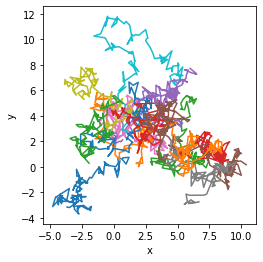

In [58]:
#Tracé de la trajectoire des particules pour 1 simulation
ax = plt.axes()
Traj=1
MD.AddParticleTraces(ax,x_tr_ens[Traj],y_tr_ens[Traj],range(NParticles))
ax.set_xlabel("x")
ax.set_ylabel("y")
ax.set_aspect(1)
plt.show()

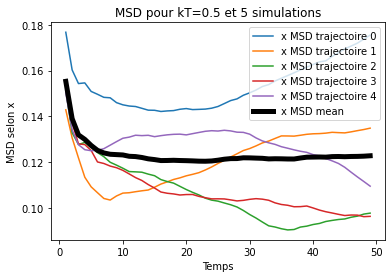

In [61]:
x_msd_ens=[]

for i in range(len(x_tr_ens)):
    delta_t, x_msd = MeanSquareDisplacements(t_tr_ens[i],x_tr_ens[i])
    plt.plot(delta_t,x_msd/delta_t,label='x MSD trajectoire {}'.format(i))
    x_msd_ens.append(x_msd)

x_msd_ens=np.array(x_msd_ens)

x_msd_ens_mean=np.mean(x_msd_ens.transpose(),axis=-1)

plt.plot(delta_t,x_msd_ens_mean/delta_t,linewidth=5,label='x MSD mean',color='black')
plt.title('MSD pour kT={} et {} simulations'.format(kT,NTrajectories))
plt.xlabel('Temps')
plt.ylabel('MSD selon x')
plt.legend()

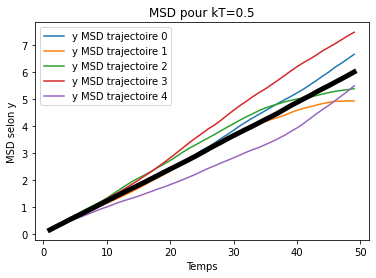

In [60]:
y_msd_ens=[]

for i in range(len(y_tr_ens)):
    delta_t, y_msd = MeanSquareDisplacements(t_tr_ens[i],y_tr_ens[i])
    plt.plot(delta_t,y_msd,label='y MSD trajectoire {}'.format(i))
    y_msd_ens.append(y_msd)

y_msd_ens=np.array(y_msd_ens)

y_msd_ens_mean=np.mean(x_msd_ens.transpose(),axis=-1)

plt.plot(delta_t,y_msd_ens_mean,linewidth=5,color='black')
    
plt.title('MSD pour kT={}'.format(kT))
plt.xlabel('Temps')
plt.ylabel('MSD selon y')
plt.legend()

## Balayage en température à $\rho$ fixé

In [4]:
rho_range=np.array([0.5])
kT_range = np.linspace(0.3,0.4,10)
print(kT_range)

[0.3        0.31111111 0.32222222 0.33333333 0.34444444 0.35555556
 0.36666667 0.37777778 0.38888889 0.4       ]


In [5]:
# When in doubt use a small number of particles to speed up the simulations
# In a perfect world (as opposed to an exam), we would generate data for different systems sizes 
# and study finite size effects.

NParticles = 32
m = np.ones(NParticles)
d = 2

# Not much fun, if we reduce this even further
NTrajectories = 10
run_time_equilibration = 2
run_time_data_acquisition = 20

print("One sweep over all state points corresponds to ", rho_range.size * kT_range.size * NTrajectories," separate simulations!")

# On my computer each of the for "sweeps" below took 2 minutes. If you are worried about time try first with
# NTrajectories = 1

One sweep over all state points corresponds to  100  separate simulations!


In [64]:
# Create empty dictionaries for the data generated by MD simulations at specific state points
t_tr_ens_from_NVT_heating = {}
x_tr_ens_from_NVT_heating = {}
y_tr_ens_from_NVT_heating = {}
vx_tr_ens_from_NVT_heating = {}
vy_tr_ens_from_NVT_heating = {}
uPot_tr_ens_from_NVT_heating = {}
uKin_tr_ens_from_NVT_heating = {}
pPot_tr_ens_from_NVT_heating = {}
pKin_tr_ens_from_NVT_heating = {}
list_of_starting_configurations_from_NVT_heating = {}


# generate trajectories and measure execution time
initialWallTime = time.perf_counter()

# sweep over densities
for rho in rho_range:
    
    # re-initialize starting configurations
    list_of_starting_configurations=[]
    for n in range(NTrajectories): 
            list_of_starting_configurations.append([])    
    

    # sweep over temperatures
    for kT in kT_range:
        i=0
        print("rho = ",rho,", kT = ",kT)
        
        # Box size
        LBox = np.power(NParticles/rho,1./d)


        # Equilibrate
        # ... reset velocities more often and hope for the best
        (t_tr_ens, x_tr_ens, y_tr_ens, vx_tr_ens, vy_tr_ens,
         uPot_tr_ens, uKin_tr_ens, pPot_tr_ens, pKin_tr_ens,
         list_of_starting_configurations
        ) = Generate_Ensemble_of_LJ_NVT_MolecularDynamics_Trajectories(d,m,LBox,kT,NTrajectories,
                                                                       run_time_equilibration,
                                                                       list_of_starting_configurations=list_of_starting_configurations,
                                                                       number_of_time_steps_between_velocity_resets=10)

        key = (NParticles,str(round(rho,3)),str(round(kT,2)))
        # using floats as key can lead to difficulties, because of their inexact representation
        print('key=',key)
                # Generate data
        run_time = 50. *tau
        (t_tr_ens_from_NVT_heating[key], 
         x_tr_ens_from_NVT_heating[key], 
         y_tr_ens_from_NVT_heating[key], 
         vx_tr_ens_from_NVT_heating[key], 
         vy_tr_ens_from_NVT_heating[key],
         uPot_tr_ens_from_NVT_heating[key], 
         uKin_tr_ens_from_NVT_heating[key], 
         pPot_tr_ens_from_NVT_heating[key], 
         pKin_tr_ens_from_NVT_heating[key],
         list_of_starting_configurations_from_NVT_heating[key]
        ) = Generate_Ensemble_of_LJ_NVT_MolecularDynamics_Trajectories(d,m,LBox,kT,NTrajectories,
                                                                       run_time_data_acquisition,
                                                                       list_of_starting_configurations=list_of_starting_configurations)

print("Execution time: ",time.perf_counter() - initialWallTime)

rho =  0.5 , kT =  0.3
key= (32, '0.5', '0.3')
rho =  0.5 , kT =  0.3111111111111111
key= (32, '0.5', '0.31')
rho =  0.5 , kT =  0.32222222222222224
key= (32, '0.5', '0.32')
rho =  0.5 , kT =  0.3333333333333333
key= (32, '0.5', '0.33')
rho =  0.5 , kT =  0.34444444444444444
key= (32, '0.5', '0.34')
rho =  0.5 , kT =  0.35555555555555557
key= (32, '0.5', '0.36')
rho =  0.5 , kT =  0.3666666666666667
key= (32, '0.5', '0.37')
rho =  0.5 , kT =  0.37777777777777777
key= (32, '0.5', '0.38')
rho =  0.5 , kT =  0.3888888888888889
key= (32, '0.5', '0.39')
rho =  0.5 , kT =  0.4
key= (32, '0.5', '0.4')
Execution time:  482.7548332000001


Pour chaque température on fait un certain nombre de trajectoires, la cellule suivante calcule le MSD en faisant la moyenne sur toutes les trajectoires pour une température.

In [65]:
x_msd_mean_from_NVT_heating=[]
y_msd_mean_from_NVT_heating=[]

for i in range(len(kT_range)):
    
    key=((NParticles,str(round(rho,3)),str(round(kT_range[i],2))))
    x_msd_ens_from_NVT_heating=[]
    y_msd_ens_from_NVT_heating=[]
    
    for j in range(len(t_tr_ens_from_NVT_heating[key])):
        
        delta_t, x_msd = MeanSquareDisplacements(t_tr_ens_from_NVT_heating[key][j],x_tr_ens_from_NVT_heating[key][j])
        delta_t, y_msd = MeanSquareDisplacements(t_tr_ens_from_NVT_heating[key][j],y_tr_ens_from_NVT_heating[key][j])
        x_msd_ens_from_NVT_heating.append(x_msd)
        y_msd_ens_from_NVT_heating.append(y_msd)
        
    x_msd_ens_from_NVT_heating=np.array(x_msd_ens_from_NVT_heating)
    y_msd_ens_from_NVT_heating=np.array(y_msd_ens_from_NVT_heating)
    x_msd_mean_from_NVT_heating.append(np.mean(x_msd_ens_from_NVT_heating.transpose(),axis=-1))
    y_msd_mean_from_NVT_heating.append(np.mean(y_msd_ens_from_NVT_heating.transpose(),axis=-1))

On plot ensuite le MSD moyen

In [6]:
for i in range(len(x_msd_mean_from_NVT_heating)):
    plt.plot(delta_t,x_msd_mean_from_NVT_heating[i]/delta_t,label='kT={}'.format(round(kT_range[i],2)))

plt.title('<MSD> pour {} trajectoires et {} particules'.format(NTrajectories,NParticles))
plt.ylabel('MSD moyen selon x')
plt.xlabel('Temps')
plt.legend()

NameError: name 'x_msd_mean_from_NVT_heating' is not defined

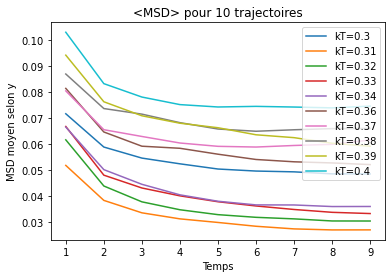

In [76]:
for i in range(len(y_msd_mean_from_NVT_heating)):
    plt.plot(delta_t,y_msd_mean_from_NVT_heating[i]/delta_t,label='kT={}'.format(round(kT_range[i],2)))

plt.title('<MSD> pour {} trajectoires'.format(NTrajectories))
plt.ylabel('MSD moyen selon y')
plt.xlabel('Temps')
plt.legend()

On remarque qu'il y a une transition de phase quelque part entre 0.3 et 0.34, maintenant, comment savoir où précisemment ?
Faut-il faire tourner les simu plus longtemps pour avoir un résultat net ?

Plus haut j'ai divisé par delta_t pour avoir le coeff de diffusion. En augmentant N_Particles, j'ai l'impression que l'effet est plus marqué. Il y a une inversion entre $kT=0.3$ et $kT=0.34$, vérifier l'ordre correctement mais ça a l'air de marcher! 